![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/20.0.Named_Entity_Disambiguation.ipynb)

# Named Entity Disambiguation

**Named Entity Disambiguation **is the task of mapping words of interest, such as names of persons, locations and companies, from an input text document to corresponding unique entities in a target Knowledge Base (KB). Words of interest are called Named Entities (NEs), mentions, or surface forms.

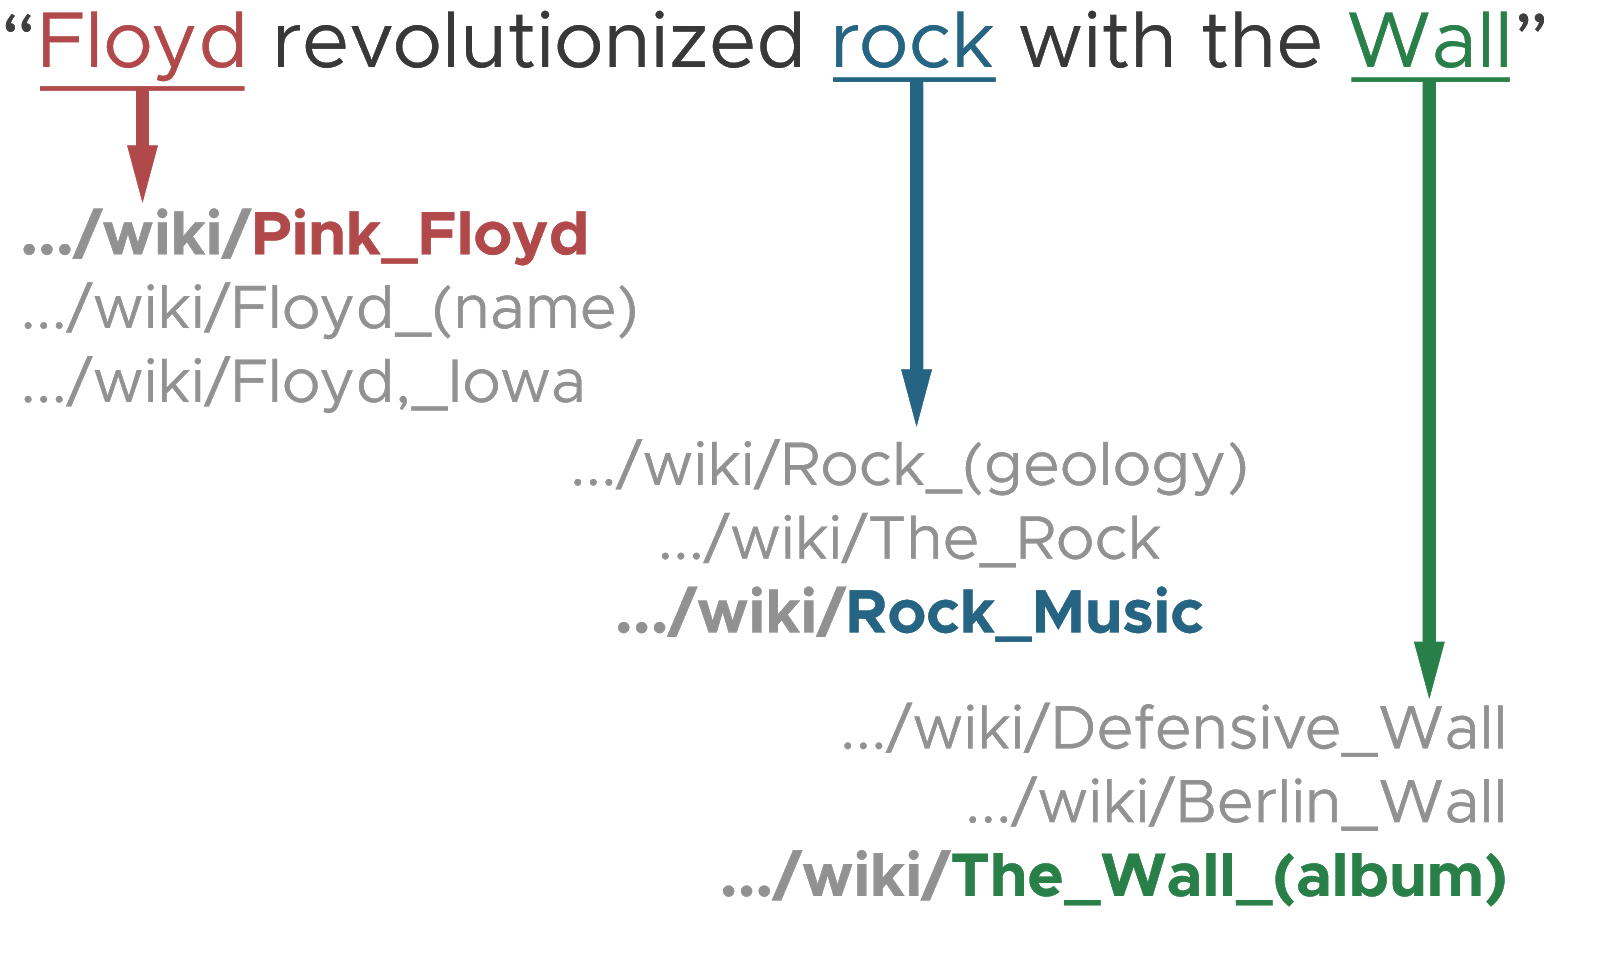

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs==5.1.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
spark

In [ ]:
# Sample data
text = "The show also had a contestant named Donald Trump " \
       + "who later defeated Christina Aguilera on the way to become Female Vocalist Champion in the 1989 edition of Star Search in the United States. "

data = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained()\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

sentence_embeddings = nlp.SentenceEmbeddings()\
    .setInputCols("sentence","embeddings")\
    .setOutputCol("sentence_embeddings")

ner_model = nlp.NerDLModel.pretrained() \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["PER"])


nlpPipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        sentence_embeddings,
        ner_model,
        ner_converter
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [ ]:
result = model.transform(data)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings| sentence_embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The show also had...|[{document, 0, 19...|[{document, 0, 18...|[{token, 0, 2, Th...|[{word_embeddings...|[{sentence_embedd...|[{named_entity, 0...|[{chunk, 37, 48, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
disambiguator = medical.NerDisambiguator() \
    .setS3KnowledgeBaseName("i-per") \
    .setInputCols("ner_chunk", "sentence_embeddings") \
    .setOutputCol("disambiguation") \
    .setNumFirstChars(5)

In [ ]:
disambiguated = disambiguator.fit(result).transform(result)

In [ ]:
disambiguated.selectExpr("explode(disambiguation)").show(10, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                                                                                                                                                                                                                                                              